# Basic Ideas of Finding Regions
Detailed exploration of the method proposed in [this paper](https://proceedings.mlr.press/v221/liu23a.html) by Liu et al. but focused on a single-layer approach.


## Outline
The idea is to show that specific activation patterns of the network partition the input space into a set of convex linear regions. 

This primal investigation will

* Investigate how this looks for one single layer. 
* Briefly visit all major aspect of finding these regions. 


### What we have:

Initially we only have a weight matrix $W$ and a bias vector $b$. This could be of one single layer, or as we shall investigate later, a concatenation of several layers. 

### Overview of what we compute:

* Activation $a=Wx+b$
* Gradient/activation pattern/bit vector: $q=a'$
* Sign vector: $s=-2q(a)+1$
* Recursive active weights $\hat{W}$. This is only important later on.
* Recursive active biases $\hat{b}$. This is only important later on. 
* Linear constraints for activation region, matrix $A$ and vector $c$ being weights and biases selected by the sign vector $s$ in order to fulfil $Ax\leq c$.
* A Linear Program (LP) determines the feasibility of the region. 
* The $\mathcal{H}$- and $\mathcal{V}$-representations are computed for the feasible regions. 

### Remarks

* Each activation pattern correspond to one distinct region, of which only a subset is feasible. 
* Hence, the maximum number of possible regions is bounded by $2^h$ with $h$ being the total number of neurons. 
* Neighbouring regions share a facet, and their gradient is separated by unit hamming distance. 


## Simulating a ReLU layer

We start by simulating a ReLU layer from $\mathbb{R}^2\to\mathbb{R}^3$. This require a $(3\times2)$ weight matrix $W$ and a $(3\times1)$ bias vector $b$:

In [420]:
import numpy as np

# Set random seed for reproducibility
# Seeds that work quite well: 45, 3, 13
np.random.seed(13)

hidden_dim = 3

W = np.random.randn(hidden_dim,2)
b = np.random.randn(hidden_dim,1)
print("W:\n", W)
print("b:\n", b)

W:
 [[-0.71239066  0.75376638]
 [-0.04450308  0.45181234]
 [ 1.34510171  0.53233789]]
b:
 [[1.3501879 ]
 [0.86121137]
 [1.47868574]]


We also need a random point in $\mathbb{R}^2$ and a ReLU function, for now we implement the ReLU function and its derivative brute force as:

\begin{equation*}
    \text{ReLU}(a) = \begin{cases}
        a \; \text{if}\; a>0 \\
        0 \; \text{if}\; a\leq 0.
    \end{cases}
\end{equation*}

\begin{equation*}
    \text{dReLU}(a) = \begin{cases}
        1 \; \text{if}\; a>0 \\
        0 \; \text{if}\; a\leq 0.
    \end{cases}
\end{equation*}

In [421]:
def ReLU(a):
    return np.maximum(a, 0)

def dReLU(a):
    return np.where(a > 0, 1, 0)

# Random point in R^2
x = np.random.randn(2,1)

In [422]:
print(f"W:\n{W}")
print(f"b:\n{b}")
print(f"x:\n{x}")

W:
[[-0.71239066  0.75376638]
 [-0.04450308  0.45181234]
 [ 1.34510171  0.53233789]]
b:
[[1.3501879 ]
 [0.86121137]
 [1.47868574]]
x:
[[-1.04537713]
 [-0.78898902]]


Next, we compute the activation $a=Wx+b$ of an input $x$, where $a\in\mathbb{R}^3$, the layer output $z=\text{ReLU}(a)$ and the gradient $q=\text{dReLU}(a)$:

In [423]:
activation = W @ x + b
print("Activation a:\n", activation)
z = ReLU(activation)
print("Output z:\n", z)
q = dReLU(activation)
print("Gradient q:\n", q)

Activation a:
 [[ 1.50019141]
 [ 0.5512589 ]
 [-0.34746158]]
Output z:
 [[1.50019141]
 [0.5512589 ]
 [0.        ]]
Gradient q:
 [[1]
 [1]
 [0]]


## Linear Model for gradients

The gradients of ReLU layers are binary vector with entries of $0$ and $1$. This can be turned into a sign vector with entries $-1$ and $1$:

\begin{equation*}
    \text{SIGN}(a) = -2q(a) + 1
\end{equation*}

This will map a vector $(1,0)\to(-1,1)$

This is useful because any datapoint $x$ with gradient $q$ and corresponding sign vector $s$ satisfies the following linearity (note that Liu uses $s'$ for the sign vector and $s$ for the bit vector, whereas here $s$ is the sign vector and $q$ is the ReLU gradient, or bit vector):

\begin{equation*}
    \text{diag}(s)(Wx+b) \leq 0
\end{equation*}

Expanding this to:

\begin{align*}
    A &= \text{diag}(s)W \\
    c &= -\text{diag}(s)b
\end{align*}

enables us to write this in a more compact way as

\begin{equation*}
    Ax\leq c
\end{equation*}.

So, each gradient vector $q$ gives rise to a convex regions, described by the solution of the linear program above. 

Let's compute these matrices for our random point $x$:

In [424]:
# Functions that find the sign vector from both the activation and the gradient. 
def SIGN_from_activation(a):
    return -2 * dReLU(a) + 1
def SIGN_from_gradient(grad):
    return np.where(grad > 0, -1, 1)

# The two function above should give the same output.
assert all(SIGN_from_activation(activation) == SIGN_from_gradient(dReLU(activation)))
sign_vector = SIGN_from_activation(activation)
print("Sign vector:\n", sign_vector)

Sign vector:
 [[-1]
 [-1]
 [ 1]]


In [425]:
Amat = np.diag(sign_vector.flatten()) @ W 
cmat = -np.diag(sign_vector.flatten()) @ b

print("Amat:\n", Amat)
print("Cmat:\n", cmat)

Amat:
 [[ 0.71239066 -0.75376638]
 [ 0.04450308 -0.45181234]
 [ 1.34510171  0.53233789]]
Cmat:
 [[ 1.3501879 ]
 [ 0.86121137]
 [-1.47868574]]


## Feasibility

The next step is to determine of the region is feasible at all. This is done by solving the linear program.

One way of defining a polyhedron in $\mathbb{R}^n$ is: $P=\{x\in\mathbb{R}^n|Ax\leq c\}$ for $A\in\mathbb{R}^{h\times n}, c\in\mathbb{h}$. This polyhedron lives in $\mathbb{R}^n$ and is constructed from $h$ constraints. If $P=\emptyset$, then the polyhedron is said to be unfeasible, or it does not exist. In other words, there are no $x\in\mathbb{R}^n$ that satisfies $Ax\leq c$. Hence, in order to show that a region is feasible, we must show that there exists at least one $x$ that satisfies all the inequalities. 

This is done by gradient descent of a random point, where the opimization objective is to minimize the constraint violation $Ax-c$. We say that such an $x$ exists if the total violation is less than some small positive tolerance, here $10^{-4}$. 

In [426]:
import torch
def check_feasibility_torch(A, c, max_iters=200, tol=1e-4, input_bound=None):
    if not isinstance(A, torch.Tensor):
        A = torch.tensor(A, dtype=torch.float32)
    if not isinstance(c, torch.Tensor):
        c = torch.tensor(c, dtype=torch.float32)

    m = A.shape[1]  # input dimension
    x = torch.randn((m, 1), requires_grad=True) # Random initialization that can be optimized
    optimizer = torch.optim.Adam([x], lr=0.05)

    for _ in range(max_iters):
        # Original inequality Ax<=c, such that any positive contribution of the following breaks the inequalities. 
        constraint_violations = A @ x - c
        
        if input_bound is not None:
            # Bounding box constraints: -bound <= x <= bound
            lower_bounds = torch.relu(-x - input_bound)
            upper_bounds = torch.relu(x - input_bound)
            
            loss = constraint_violations.sum() + lower_bounds.sum() + upper_bounds.sum()
        else:
            loss = torch.relu(constraint_violations).sum()
            
        if loss.item() < tol:
            return True
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return False

We would expect any $A$ and $c$ generated from an actual example point to be feasible, this follows from the definition of feasible region. 

In [427]:
check_feasibility_torch(Amat,cmat)

True

## Computing Regions - $\mathcal{H}$-representation

In theory, there exist one unique region for each activation patter/bit vector/gradient $q$. If a layer has $h$ neurons, then this layer would split its own input space into $2^h$ possible regions from $h$ hyperplanes creating $2h$ half spaces. Hence, the maximum number of regions induced by $h$ neurons is $2^h$. For small networks, or small layers, we can just enumerate through all activation patterns and keep feasible regions. This is infeasible for larger networks due to the combinatorial increase of regions both when the number of neurons increase but also when more hidden layers are present. This is supported by the findings of [Hanin & Rolnick](https://proceedings.neurips.cc/paper_files/paper/2019/file/9766527f2b5d3e95d4a733fcfb77bd7e-Paper.pdf) where they report that deep ReLU network have surprisingly few activation patterns. 

However, for now we focus on the brute force method to gain some intuition as to how these regions are formed. Our single layer example consists of a $3$-neuron configuration. This will create a maximum of $2^3=8$ regions. These regions will be indexed by $k\in[1,2^h]$ 

This is how we find the $\mathcal{H}$-representation of the feasible regions:
* For each gradient $q^k$, compute the corresponding sign vector $s^k$. 
* Construct their $A^k=\text{diag}(s^k)W$ and $c^k = -\text{diag}(s^k)b$ from $s^k$ and the weights and biases.
* Assert whether there exists and $x$ such that $A^kx\leq c^k$. 
* For the feasible regions: $A^k$ and $c^k$ defines a set of hyperplanes whose solutions make up the convex region. 

Remarks: 
* $s$ is just $1$ and $-1$. Hence, the magnitude of the entries of both $A^k$ and $c^k$ will be purely determined by $W$ and $b$ which is unique for each layer. Hence, $A^k$ and $c^k$ will create the same hyperplanes for all $k$-s. The distnction is the orientation that will vary with the sign vector $s$, and determine which half-space has feasible values fore each region $k$. 
* For now, we allow $A^k$ and $c^k$ to create redundant inequalities. This will be addressed later. 

In [428]:
from dataclasses import dataclass

# Class to represent a region in the input space. 
@dataclass
class Region:
    q: tuple 
    s: tuple
    feasible: bool
    A: np.ndarray
    c: np.ndarray
    H_representation: np.ndarray = None
    V_representation: np.ndarray = None

In [429]:
import itertools
# Make a list of all possible bit vector with length h.
def generate_all_bit_vectors(h):
    return list(itertools.product([0, 1], repeat=h))

In [430]:
# Compute and store region for each bit vector. 
regions = []
for bit_vector in generate_all_bit_vectors(len(W)):
    sign_vector = SIGN_from_gradient(np.array(bit_vector))
    Amat = np.diag(sign_vector.flatten()) @ W
    cmat = -np.diag(sign_vector.flatten()) @ b
    feasible = check_feasibility_torch(Amat, cmat)
    regions.append(Region(q=bit_vector, s=sign_vector, feasible=feasible, A=Amat, c=cmat))

In [431]:
# Print the regions, both the gradient and sign vector and feasibility
for region in regions:
    print(f"Region q: {region.q}, s: {region.s}, feasible: {region.feasible}" )

Region q: (0, 0, 0), s: [1 1 1], feasible: True
Region q: (0, 0, 1), s: [ 1  1 -1], feasible: True
Region q: (0, 1, 0), s: [ 1 -1  1], feasible: False
Region q: (0, 1, 1), s: [ 1 -1 -1], feasible: True
Region q: (1, 0, 0), s: [-1  1  1], feasible: True
Region q: (1, 0, 1), s: [-1  1 -1], feasible: True
Region q: (1, 1, 0), s: [-1 -1  1], feasible: True
Region q: (1, 1, 1), s: [-1 -1 -1], feasible: True


## $\mathcal{V}$-representation

So far, we have a set of inequalities from $A^k$ and $c^k$ for each region $k$. These make up the $\mathcal{H}$-representation carving up the input space into a collection of intersecting half-planes. The convex regions consist of intersections of feasible half planes. Another way of defining the same regions is to consider the convex hull $conv(\mathcal{V})$ of the set $\mathcal{V}$ of vertices. Each vertex will be an intersecting point of two or more half-plane boundaries. 

The mathematical intuition comes from the fact that any point $v\in\mathcal{P}^k$ where $\mathcal{P}^k=\{x\in\mathbb{R}^n: A^kx\leq c^k\}$ is extreme point, or vertex, iff it cannot be written as a strict convex combination of two other points in $\mathcal{P}^k$. Here, $A^k\in\mathbb{R}^{h\times n}$ and $c^k\in\mathbb{R}^h$, where $k\in[1,2^h]$ is the region and $h$ is the number of neurons in the layer we are working with. Each row $(a^k_i)^T v\leq c^k_i$ represent an inequality that correspond to one facet of the region, and also defines a closed half-space. 

The most brute force and intuitive way of computing vertices is to realise that we need at least $n$ hyperplanes/inequalitites in order to fix an isolated point. We therefore pick a subset of $n$ constraints: $\mathcal{I}\subset\{1,\dots,h\}$, where $|\mathcal{I}|=n$. There are $h\choose n$ such subsets, so this is infeasible for large $h$. $\mathcal{I}$ is a set of $n$ indices that select the corresponding rows of the total inequality matrices $A^k$ and $c^k$. We must also demand that $\text{Rank}(A^k_\mathcal{I}) = n$, otherwise a solution will not be unique. 

For each $\mathcal{I}$ we find $x*$ such that:
* $A^k_\mathcal{I}x*=c^k_\mathcal{I}$
* If $x*$ also satisfies the other inequalities $A^kx*\leq c^k$ then $x*$ is a vertex of region $k$. 

As long as region $k$ is bounded, this method will find all vertices. The maximum number of vertices for each region is always $h\choose n$ (?show this maybe?). 

In [432]:
def vertices_from_H_enumeration(A, c, tol=1e-9):
    """
    Compute vertices of P = { x | A x <= c } in R^n by enumerating combinations of n constraints.
    A: (h, n) numpy array
    c: (h, 1) or (h,) numpy array
    Returns: vertices
    """
    A = np.asarray(A, dtype=float)
    c = np.asarray(c, dtype=float).reshape(-1)
    h, n = A.shape
    vertices = []

    # enumerate combinations of n rows
    for idxs in itertools.combinations(range(h), n):
        A_sub = A[list(idxs), :]
        # skip singular subsets
        if np.linalg.matrix_rank(A_sub) < n:
            continue
        c_sub = c[list(idxs)]
        try:
            x = np.linalg.solve(A_sub, c_sub)
        except np.linalg.LinAlgError:
            continue
        # Test feasibility
        if np.all(A.dot(x) <= c + 1e-8 + tol):
            vertices.append(np.round(x, 12)) # Reduce numerical duplicates by rounding
    if not vertices:
        return np.zeros((0, n))

    verts = np.unique(np.vstack(vertices), axis=0)
    return verts

feasible_regions = [region for region in regions if region.feasible]
for region in feasible_regions:
    region.V_representation = vertices_from_H_enumeration(region.A, region.c)

## Extreme rays

If a region is unbounded that means it stretches to infinity. In that case, there are no vertices whose convex hull make out the region. Instead, the Weyl-Minkowski theorem says that any polyhedral region can be expressed as:

\begin{equation}
    \mathcal{P} = \text{Conv}(\mathcal{V})+\text{Cone}(\mathcal{R}),
\end{equation}
where $\mathcal{V}$ are the vertices and $\mathcal{R}$ are the rays. If the region is bounded, then $\text{Cone}(\mathcal{R})=\emptyset$. A ray is any direction $r\in\mathbb{R}^n$ for which $x+\lambda r\in\mathcal{P}$ $\forall x\in\mathcal{P}$ and $\lambda\geq0$. Consequently, while moving in the direction of $r$, you would never leave the region. Hence, $A^k r\leq 0$.

In [433]:
def extreme_rays(A, tol=1e-9):
    """
    Find candidate extreme rays for polyhedron {x | A x <= c}.
    Only recession cone, no c used.
    Works reliably in 2D.
    """
    m, n = A.shape
    rays = []
    # In 2D, check each row normal -> boundary line of cone
    for i in range(m):
        ai = A[i]
        # find perpendicular direction candidate
        perp = np.array([ai[1], -ai[0]])  # rotate by 90 degrees
        # test both directions
        for r in [perp, -perp]:
            if np.all(A @ r <= tol):
                r = r / np.linalg.norm(r)
                rays.append(tuple(np.round(r,6)))  # normalized
    # deduplicate
    rays = list(set(rays))
    return np.array(rays)

## Plotting results in simple example



In [434]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def constraint_plot_limits(A, c, margin=0.5):
    points = []
    m = A.shape[0]
    for i in range(m):
        for j in range(i+1, m):
            Ai, ci = A[i], c[i][0]
            Aj, cj = A[j], c[j][0]
            M = np.vstack([Ai, Aj])
            if np.linalg.matrix_rank(M) == 2:  # avoid parallel lines
                b = np.array([ci, cj])
                x = np.linalg.solve(M, b)
                points.append(x)
    if not points:
        return (-1, 1), (-1, 1)  # default
    pts = np.array(points)
    xmin, xmax = pts[:,0].min() - margin, pts[:,0].max() + margin
    ymin, ymax = pts[:,1].min() - margin, pts[:,1].max() + margin
    return (xmin, xmax), (ymin, ymax)


def plot_region(region, ax=None, feasible_pt=None, anchor=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    # Compute global limits from constraints
    plot_xlim, plot_ylim = constraint_plot_limits(region.A, region.c, margin=0.5)
    
    arrow_scaling = ((plot_xlim[1] - plot_xlim[0])+plot_ylim[1] - plot_ylim[0]) / 2 * 0.10
    
    xs = np.linspace(plot_xlim[0], plot_xlim[1], 400)
    ys = np.linspace(plot_ylim[0], plot_ylim[1], 400)
    XX, YY = np.meshgrid(xs, ys)

    for i in range(region.A.shape[0]):
        a1, a2 = region.A[i]
        ci = region.c[i][0]
        
        # Boundary line
        if abs(a2) > 1e-12:
            line_ys = (ci - a1 * xs) / a2
            line_handle, = ax.plot(xs, line_ys, label=f"{a1:.2f} x1 + {a2:.2f} x2 <= {ci:.2f}")
            color = line_handle.get_color()
        else:
            x_vert = ci / a1
            line_handle = ax.axvline(x_vert, label=f"{a1:.2f} x1 <= {ci:.2f}")
            color = line_handle.get_color()
        
        # Half-plane shading
        mask = (a1 * XX + a2 * YY) <= ci
        ax.contourf(XX, YY, mask, levels=[0.5, 1], colors=[color], alpha=0.08)
        
        normal = np.array([a1, a2], dtype=float)
        if feasible_pt is not None:
            if a1 * feasible_pt[0] + a2 * feasible_pt[1] <= ci:
                feasible_dir = normal
            else:
                feasible_dir = -normal
        else:
            feasible_dir = normal
        feasible_dir /= np.linalg.norm(feasible_dir)
        
        # Midpoint on line in plot range
        xm_center = 0.5 * (plot_xlim[0] + plot_xlim[1])
        if abs(a2) > 1e-12:
            ym_center = (ci - a1 * xm_center) / a2
        else:
            xm_center = ci / a1
            ym_center = 0.5 * (plot_ylim[0] + plot_ylim[1])
        
        
        arrow_start = np.array([xm_center, ym_center]) + 0.05 * feasible_dir
        arrow_end   = arrow_start + arrow_scaling * feasible_dir
        ax.annotate("", xy=arrow_end, xytext=arrow_start,
                    arrowprops=dict(facecolor=color, edgecolor=color, width=1.5, headwidth=6))
    
    # Polygon of feasible region
    if region.V_representation.shape[0] > 0:
        poly = Polygon(region.V_representation, closed=True, alpha=0.3, facecolor='red', edgecolor='black', hatch=r"//")
        ax.add_patch(poly)
        ax.scatter(region.V_representation[:, 0], region.V_representation[:, 1],
                   color='red', zorder=5, label="Vertices")
    
    
    ### RAYS
    rays = extreme_rays(region.A)
    # Draw rays
    for r in rays:
        r = r / np.linalg.norm(r)  # normalize
        for v in region.V_representation:
            ax.arrow(v[0], v[1], arrow_scaling*r[0], arrow_scaling*r[1],
                    head_width=0.02, head_length=0.01, fc='blue', ec='blue', lw=5,
                    length_includes_head=True)

    
    ax.set_xlim(*plot_xlim)
    ax.set_ylim(*plot_ylim)
    # ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title("Feasible Half-planes in $\\mathbb{R}^2$"+f"for q={region.q}")
    return ax
    

# plot_region(feasible_regions[0], anchor=None, ray_len=0.4)

In [435]:
import math

def best_subplot_shape(N):
    n = math.ceil(math.sqrt(N))  # number of columns
    m = math.ceil(N / n)         # number of rows
    return (m, n)

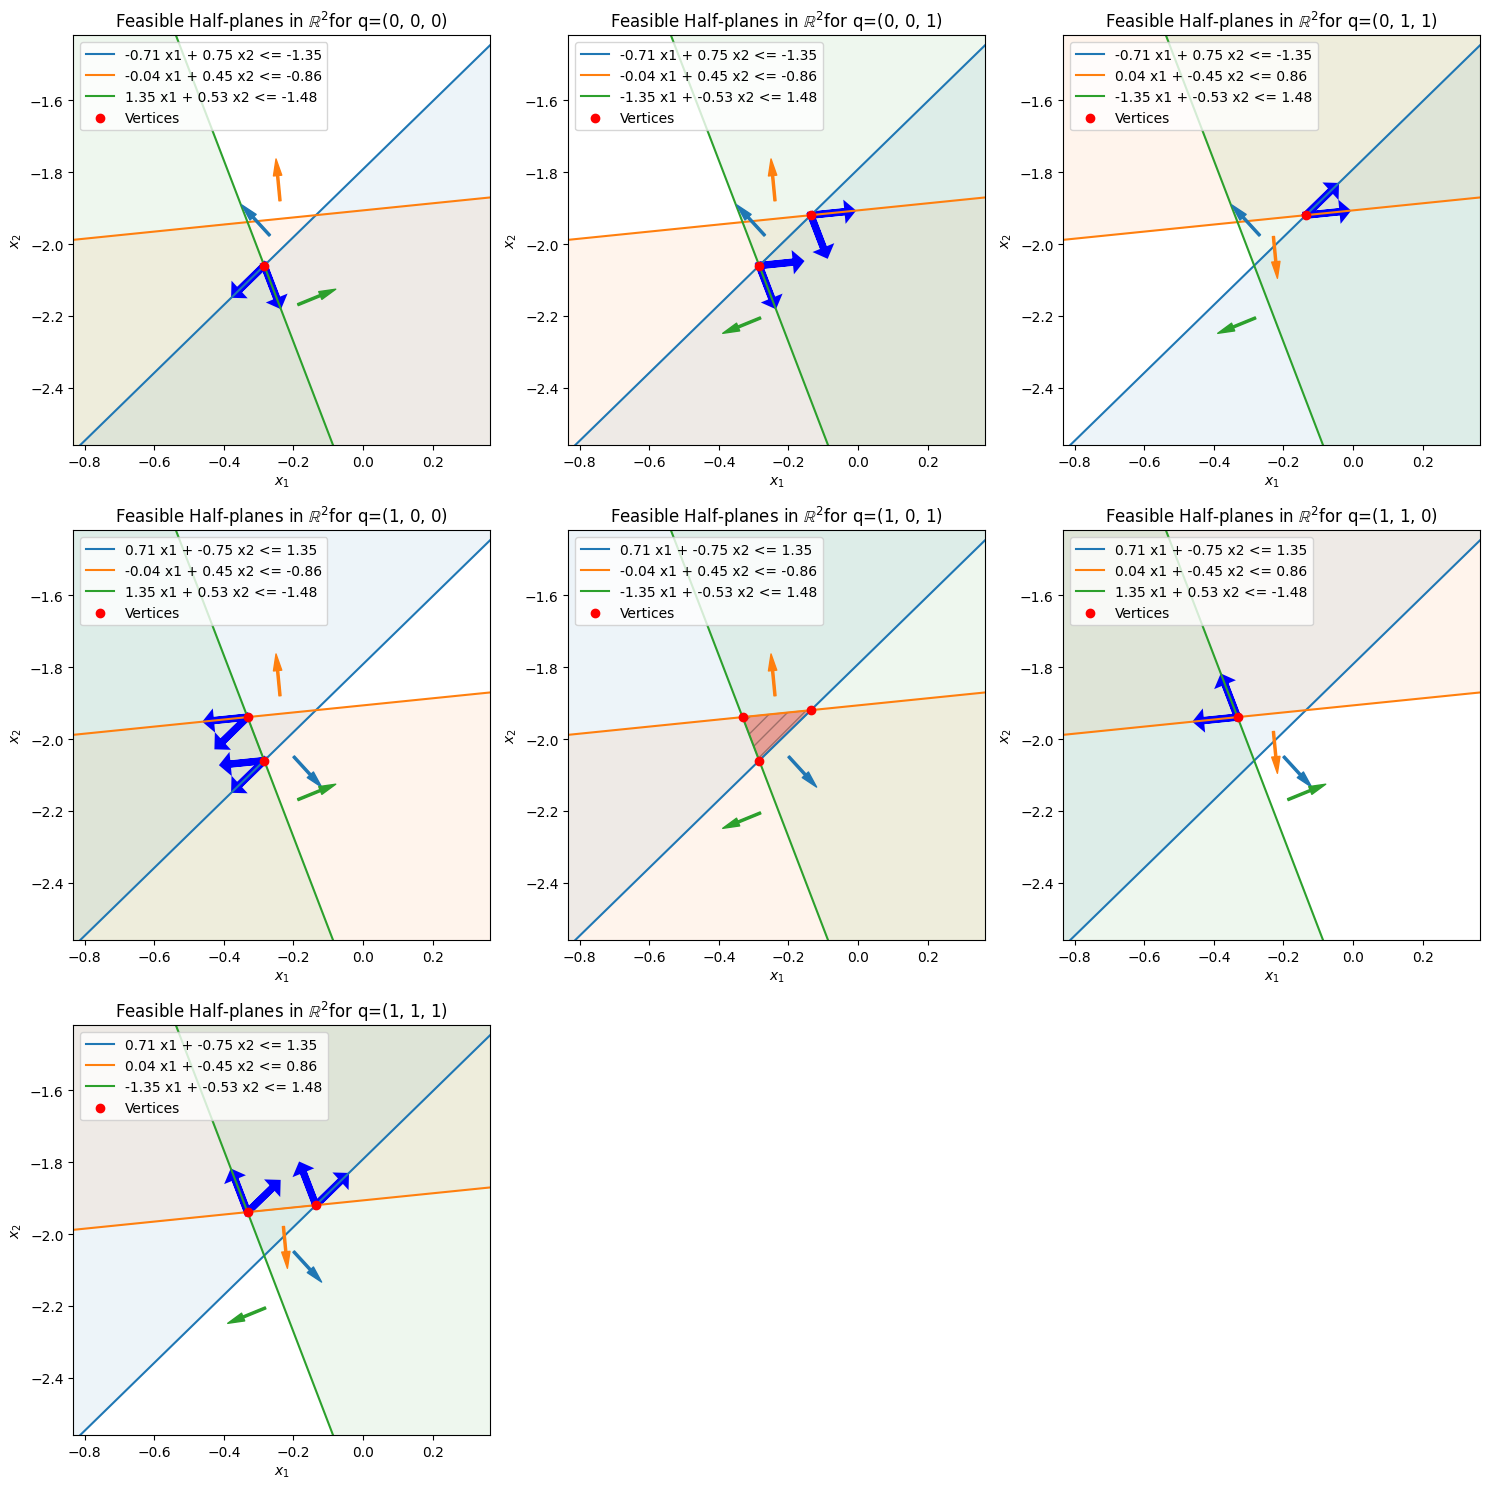

In [436]:
def plot_all_regions(feasible_regions):
    m, n = best_subplot_shape(len(feasible_regions))  # rows, cols
    fig, axes = plt.subplots(m, n, figsize=(5*n, 5*m))  # scale figsize with grid size
    axes = axes.flatten()  # make it a flat array for easy indexing

    for i, region in enumerate(feasible_regions):
        ax = axes[i]
        plot_region(region, ax=ax)  # <-- pass ax explicitly
        # ax.set_title(f"Region {i+}")

    # Hide unused subplots (if grid > number of regions)
    for j in range(len(feasible_regions), m*n):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
plot_all_regions(feasible_regions)

## More the number of Neurons in Hidden Layers?



Region q: (0, 0, 0, 0), s: [1 1 1 1], feasible: False
Region q: (0, 0, 0, 1), s: [ 1  1  1 -1], feasible: True
Region q: (0, 0, 1, 0), s: [ 1  1 -1  1], feasible: False
Region q: (0, 0, 1, 1), s: [ 1  1 -1 -1], feasible: True
Region q: (0, 1, 0, 0), s: [ 1 -1  1  1], feasible: False
Region q: (0, 1, 0, 1), s: [ 1 -1  1 -1], feasible: False
Region q: (0, 1, 1, 0), s: [ 1 -1 -1  1], feasible: True
Region q: (0, 1, 1, 1), s: [ 1 -1 -1 -1], feasible: True
Region q: (1, 0, 0, 0), s: [-1  1  1  1], feasible: True
Region q: (1, 0, 0, 1), s: [-1  1  1 -1], feasible: True
Region q: (1, 0, 1, 0), s: [-1  1 -1  1], feasible: False
Region q: (1, 0, 1, 1), s: [-1  1 -1 -1], feasible: True
Region q: (1, 1, 0, 0), s: [-1 -1  1  1], feasible: True
Region q: (1, 1, 0, 1), s: [-1 -1  1 -1], feasible: True
Region q: (1, 1, 1, 0), s: [-1 -1 -1  1], feasible: True
Region q: (1, 1, 1, 1), s: [-1 -1 -1 -1], feasible: True


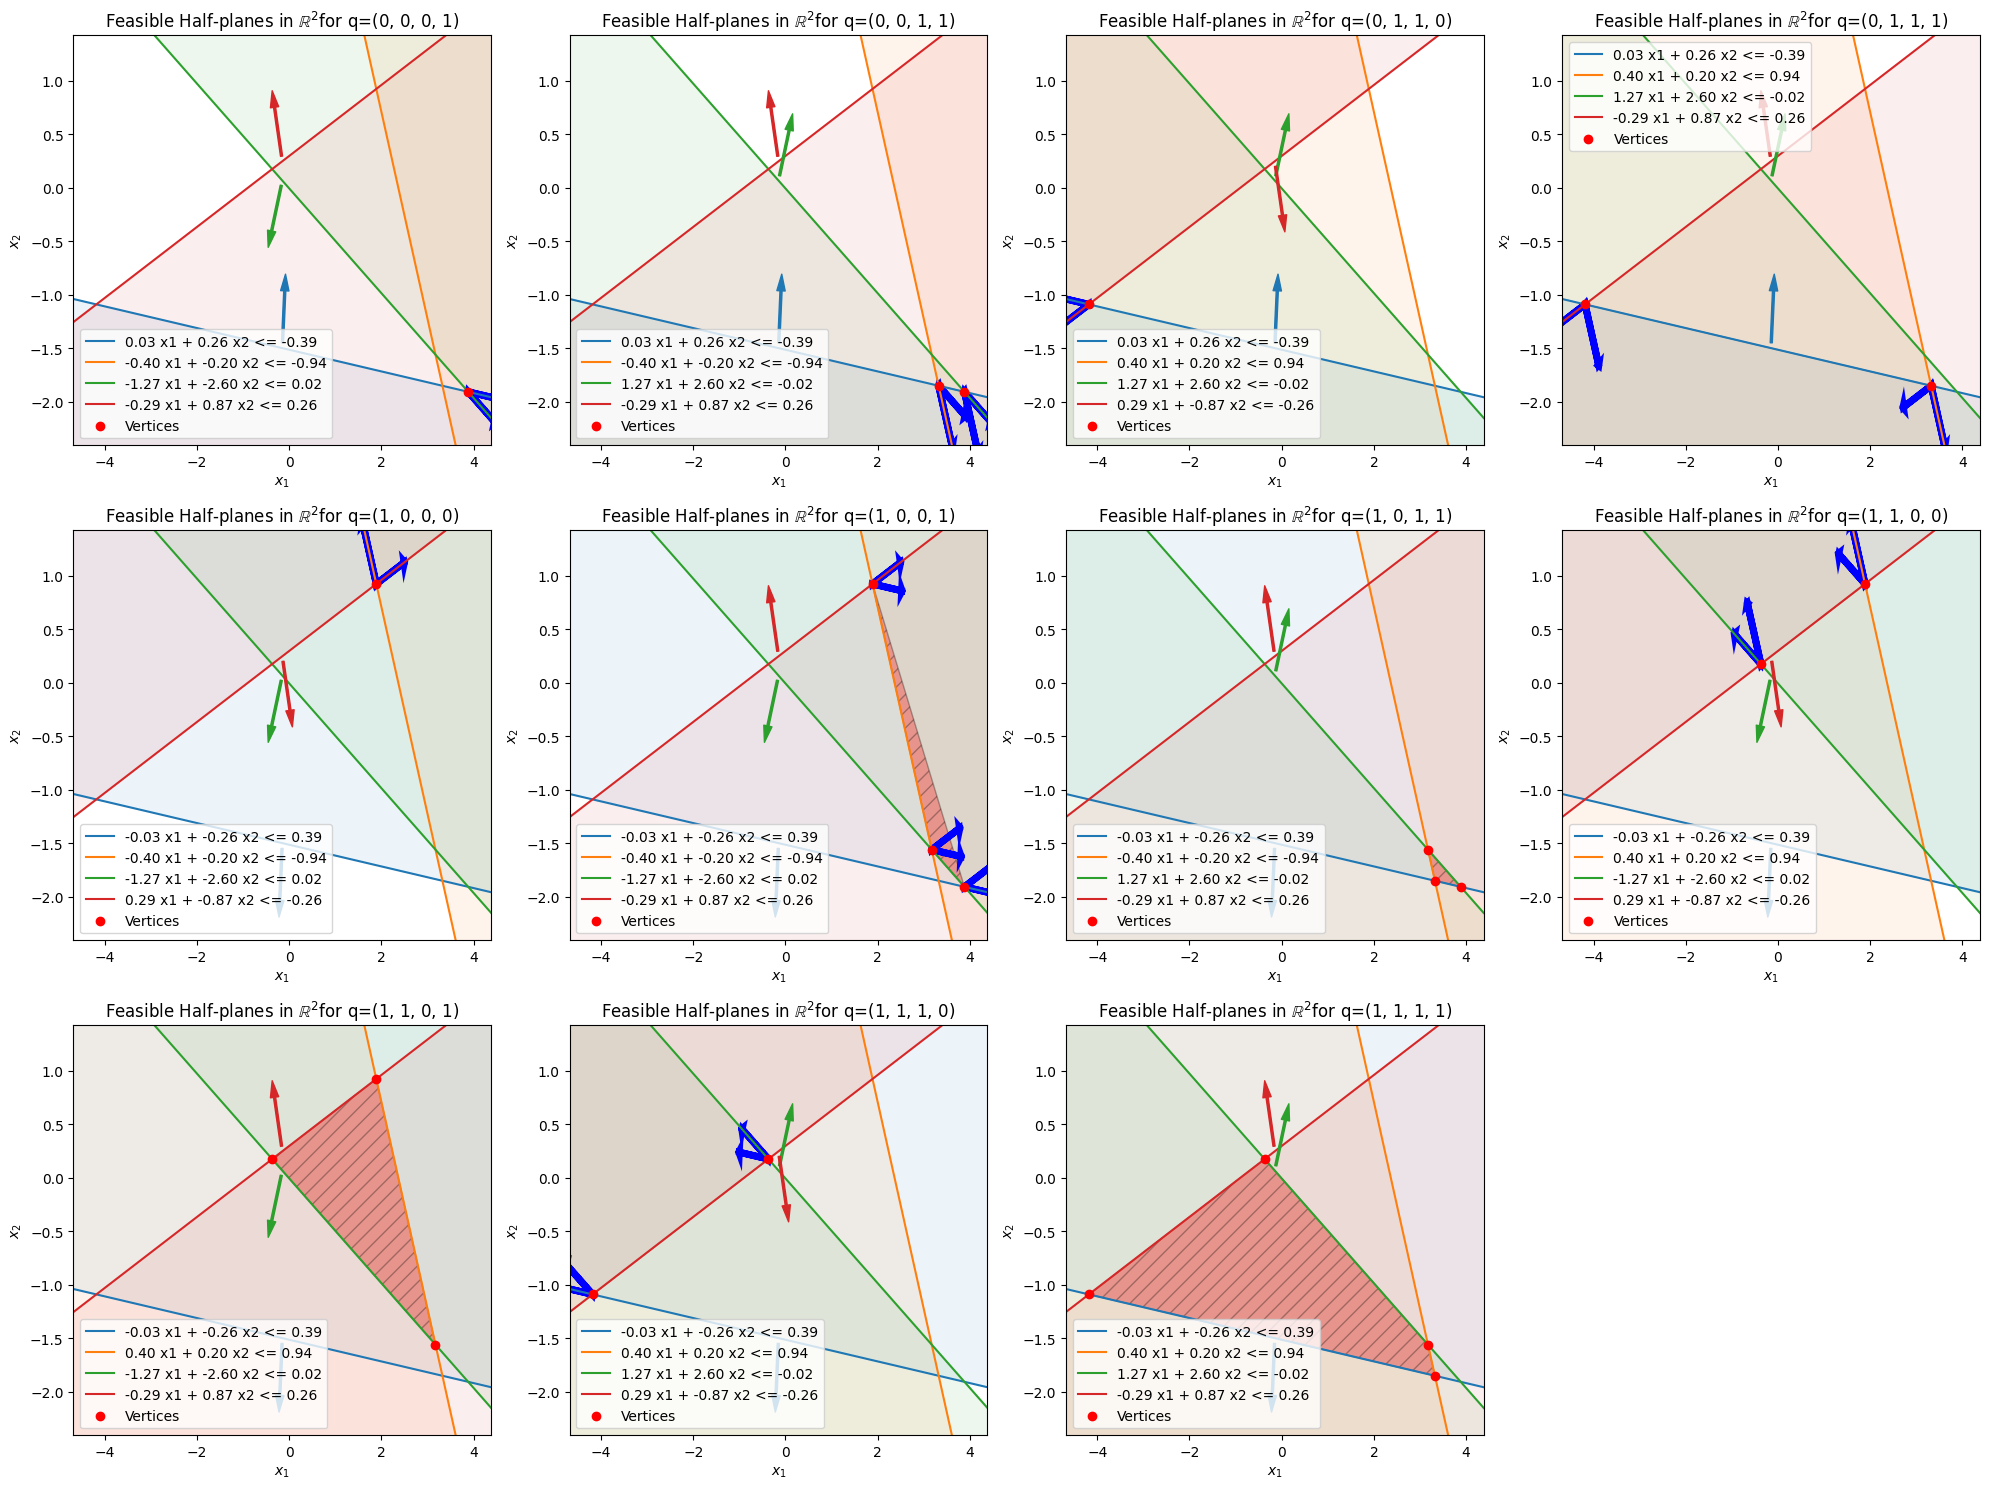

In [437]:
# Seeds that work quite well: 45, 3, 13
np.random.seed(45)
test_hidden_dim = 4

# Step 1 - get weights and biases
W_test = np.random.randn(test_hidden_dim, 2)
b_test = np.random.randn(test_hidden_dim, 1)

# Step 2 - generate regions
test_regions = []
for bit_vector in generate_all_bit_vectors(len(W_test)):
    # 2a - compute sign vector
    sign_vector = SIGN_from_gradient(np.array(bit_vector))
    # 2b - compute region constraints
    Amat = np.diag(sign_vector.flatten()) @ W_test
    cmat = -np.diag(sign_vector.flatten()) @ b_test
    # 2c - check feasibility
    feasible = check_feasibility_torch(Amat, cmat)
    test_regions.append(Region(q=bit_vector, s=sign_vector, feasible=feasible, A=Amat, c=cmat))

# Step 3 - Keep feasible regions
for region in test_regions:
    print(f"Region q: {region.q}, s: {region.s}, feasible: {region.feasible}" )
feasible_test_regions = [region for region in test_regions if region.feasible]

# Step 4 - Calculate V-representation of feasible regions
for region in feasible_test_regions:
    region.V_representation = vertices_from_H_enumeration(region.A, region.c)
    
# Step 5 - Plot regions
plot_all_regions(feasible_test_regions)

## Multiple Layers

### Recursive weight matrices

They propose a recursive weight matrices and bias vectors for layer $l$: 

\begin{equation*}
    \hat{W}_l = W_l\text{diag}(q_{l-1})\hat{W}_{l-1}
\end{equation*}

and

\begin{equation}
    \hat{b}_l = W_l\text{diag}(q_{l-1})\hat{b}_{l-1}
\end{equation}
for $2\leq l \leq L$ and $\hat{W}_1=W_1$ and $\hat{b}_1 = b_1$

In [438]:
# Testing only

W2 = np.random.randn(4,3)
W3 = np.random.randn(3,4)
b2 = np.random.randn(4,1)
b3 = np.random.randn(3,1)

a2 = W2 @ ReLU(activation) + b2
a3 = W3 @ ReLU(a2) + b3

q2 = dReLU(a2)
q3 = dReLU(a3)

s1 = sign_vector
s2 = SIGN_from_gradient(q2)
s3 = SIGN_from_gradient(q3)

What1 = W
bhat1 = b 

What2 = W2 @ np.diag(s1.flatten()) @ What1
bhat2 = W2 @ np.diag(s1.flatten()) @ bhat1 

What3 = W3 @ np.diag(s2.flatten()) @ What2
bhat3 = W3 @ np.diag(s2.flatten()) @ bhat2


bit_vectors_layer1 = generate_all_bit_vectors(len(W))
bit_vectors_layer2 = generate_all_bit_vectors(len(W2))
bit_vectors_layer3 = generate_all_bit_vectors(len(W3))

print(bit_vectors_layer2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [ ]:
import os, sys
sys.path.append('../')
from src import utils

model = utils.NeuralNet(input_size=2, num_classes=1, hidden_sizes=[3,4])


In [ ]:
@dataclass
class Layer:
    name: str
    W: np.ndarray
    b: np.ndarray
    
layers = []
bit_vectors_per_layer = []
for key, val in model.state_dict().items():
    if 'weight' in key:
        layer_name = key.split('.')[0]
        layer = Layer(name=layer_name, W=val, b=model.state_dict()[f"{layer_name}.bias"].unsqueeze(-1))
        layers.append(layer)
        bit_vectors_per_layer.append(generate_all_bit_vectors(layer.W.shape[0]))


In [ ]:
layer_count = 1
for layer in layers:
    print(f"Layer {layer.name}: W shape {layer.W.shape}, b shape {layer.b.shape}")
    weight = layer.W
    bias = layer.b
    
    if layer_count == 1:
        continue
    else:
        weight 
    
    for bit_vector in generate_all_bit_vectors(weight.shape[0]):
        sign_vector = torch.tensor(SIGN_from_gradient(np.array(bit_vector)), dtype=torch.float32)
        Amat = torch.diag(sign_vector.flatten()) @ weight
        cmat = -torch.diag(sign_vector.flatten()) @ bias
        
        if check_feasibility_torch(Amat, cmat):
            print(f"Layer {layer.name}, Bit vector {bit_vector} is feasible.")
        else:
            print(f"Layer {layer.name}, Bit vector {bit_vector} is infeasible.")
    

Layer l1: W shape torch.Size([3, 2]), b shape torch.Size([3, 1])
Layer l2: W shape torch.Size([4, 3]), b shape torch.Size([4, 1])
Layer l3: W shape torch.Size([1, 4]), b shape torch.Size([1, 1])


## Convex regions (polytopes/polyhedra)

The central idea is that points that share the same gradient $q$ belong to the same convex regions. We therefore define a convex polytope $\mathcal{P}$ in $\mathbb{R}^2$ (input space) as the set $\{ x'| q(x') = q(x) \forall x'\in\mathbb{R}^2 \}$